<a href="https://colab.research.google.com/github/Zorug/Steam-Stuff/blob/master/BS_%26_CSV_compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Info

comparação com os dados do site: https://www.steamcardexchange.net 

extração do csv: https://steam.tools/cards/

In [1]:
""" info da columns:
Game: Name of the set's game
# Cards: Number of cards in the set
Set Price: The total price of all the cards for the set
Card Avg: The averege price of a card in the set
Booster Avg: The average price of a card from the set's booster
Booster %: How many percent cheaper avarage booster cards are for the set
Emote Avg: The average price of the set's emoticons
BG Avg: The average price of the set's bachgrounds
Avg Qty: The average quantity of items on the market
Discount: The money you would make by selling all your drops for that game
Added: The date the set was added
"""

" info da columns:\nGame: Name of the set's game\n# Cards: Number of cards in the set\nSet Price: The total price of all the cards for the set\nCard Avg: The averege price of a card in the set\nBooster Avg: The average price of a card from the set's booster\nBooster %: How many percent cheaper avarage booster cards are for the set\nEmote Avg: The average price of the set's emoticons\nBG Avg: The average price of the set's bachgrounds\nAvg Qty: The average quantity of items on the market\nDiscount: The money you would make by selling all your drops for that game\nAdded: The date the set was added\n"

# Importanto libs e dados

In [2]:
import pandas as pd

csv_source = 'STC_set_data.csv'
#csv_source = 'https://raw.githubusercontent.com/Zorug/Steam-Stuff/master/STC_set_data.csv'
dados_csv = pd.read_csv(csv_source)
qnt_dados = dados_csv.shape[0]
qnt_dados

9177

In [3]:
dados_csv.sample(2)

,Game,# Owned,# Unique,# Cards,Badge Lvl,Set Price,Price Diff,Card Avg,Booster Avg,Booster %,Emote Avg,BG Avg,Avg Qty,Discount,Added,AppId
6227,Fake Colours,0,0,8,0,0.28,0.28,0.04,0.02,50.0,0.03,0.03,1761,0.14,2016-01-06,334300
8753,Velocity®Ultra,0,0,9,0,0.43,0.43,0.05,0.04,20.0,0.04,0.09,112,0.22,2013-12-12,244890


#Organizando DataSet

## Removendo dados inúteis para o teste

In [0]:
dados_csv = dados_csv.drop(['# Owned', '# Unique', 'Badge Lvl','Emote Avg', 'BG Avg', 'Discount', 'Added'], axis = 1)

In [5]:
dados_csv.sample(2)

,Game,# Cards,Set Price,Price Diff,Card Avg,Booster Avg,Booster %,Avg Qty,AppId
3762,QUACK ATTACK 1985,6,0.45,0.45,0.07,NaN,0.0,18,500340
501,ULTIMATE HARDBASS DEFENCE,5,0.51,0.51,0.10,0.12,-20.0,55,915460


##Reorganizando os tipos

In [6]:
dados_csv.dtypes

Game            object
# Cards          int64
Set Price       object
Price Diff      object
Card Avg       float64
Booster Avg    float64
Booster %       object
Avg Qty          int64
AppId            int64
dtype: object

In [0]:
def remove_virgula_perdida(sentenca): # aqui estamos esvitando um erro de conversão
    sentenca = sentenca.replace(',','')
    return sentenca

In [0]:
para_float = ['Set Price', 'Price Diff', 'Booster %']
for coluna in dados_csv[para_float]:
    dados_csv[coluna] = dados_csv[coluna].apply(remove_virgula_perdida)

dados_csv[para_float] = dados_csv[para_float].astype('float64')
dados_csv['AppId'] = dados_csv['AppId'].astype('str')

In [9]:
dados_csv.dtypes

Game            object
# Cards          int64
Set Price      float64
Price Diff     float64
Card Avg       float64
Booster Avg    float64
Booster %      float64
Avg Qty          int64
AppId           object
dtype: object

#Me parece que o price Diff é o mesmovalor do set price, será?

In [10]:
teste = dados_csv[['Set Price', 'Price Diff']]
teste['Diferença'] = teste['Set Price'] - teste['Price Diff']
teste.query('Diferença != 0.0')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Set Price,Price Diff,Diferença


se não há diferença então são iguais

In [0]:
dados_csv = dados_csv.drop('Price Diff', axis=1)

# BeautifulSoup

In [0]:
import bs4
from urllib.request import urlopen
from bs4 import BeautifulSoup

In [0]:
def arruma_string(string_to_go):
  if(string_to_go == 'A'): return 'nan'
  elif(string_to_go[0] == 'n'): return string_to_go[4:]
  else: return string_to_go

def captura_dados_cartas(soup):
  cards_script = soup.find("div",{"id":"cards"})
  card_list = cards_script.findAll("div",{"class":"showcase-element"})
  temporario = []
  for item in card_list: # retira itens vazios
    if not item.a == None: temporario.append(item)
  card_list = temporario

  precos_das_cartas = []
  for item in card_list: 
    try: 
      precos_das_cartas.append( arruma_string( ((item.find("div", {"class":"element-button"})).text)[8:] ) )
    except:
      print('Arumando erro 368020, sem valor para carta... adicinonando NaN')
      precos_das_cartas.append( 'nan' )

  precos_das_cartas = pd.Series(precos_das_cartas).apply(remove_virgula_perdida).astype('float64')

  return precos_das_cartas

In [0]:
def captura_dados_booster(soup):
  booster_script = soup.find("div",{"id":"booster"})

  try:
    sub_script = (booster_script.find("div",{"class":"showcase-element-container booster"}))
    booster_title = sub_script.img["alt"]
    preco_booster = arruma_string( ((sub_script.find("a", {"class":"button-blue"})).text)[8:] )
  except:
    print('Erro de booster inexistente.')
    booster_title = '------'
    preco_booster = 'nan'

  preco_booster = pd.Series(preco_booster).apply(remove_virgula_perdida).astype('float64').values[0]
  
  return booster_title, preco_booster

In [0]:
def arredonda(valor, casas = 2):
  return round(valor, casas)

In [16]:
list_index_sample = []
list_booster_title = []
list_booster_price = []
list_set_price = []
list_card_mean = []

for i in range(150):
#for i in range(qnt_dados):
  amostra = dados_csv.sample(1)
  #amostra = dados_csv[dados_csv.index == i]
  AppId = amostra['AppId'].values[0]
  url = 'https://www.steamcardexchange.net/index.php?gamepage-appid-'+AppId

  uClient = urlopen(url)
  page_html = uClient.read()
  uClient.close()

  soup = BeautifulSoup(page_html, 'html.parser')

  precos_das_cartas = captura_dados_cartas(soup)
  booster_title, preco_booster = captura_dados_booster(soup)

  #print('tipo do preço das cartas:', type(precos_das_cartas))

  #print(AppId)
  #print('índice:',amostra['AppId'].index[0])
  list_index_sample.append(amostra['AppId'].index[0])
  #print('Preços das cartas =', precos_das_cartas.values)
  #print('Set Price =', arredonda(precos_das_cartas.sum()))
  list_set_price.append(arredonda(precos_das_cartas.sum()))

  #print('Card Avg =', arredonda(precos_das_cartas.mean()))
  list_card_mean.append(arredonda(precos_das_cartas.mean()))
  #print('Título:', booster_title)
  list_booster_title.append(booster_title)
  #print('Preço do booster:', preco_booster)
  list_booster_price.append(preco_booster)
  #print('')

Erro de booster inexistente.


# Comparações

In [0]:
#list_index_sample

In [18]:
dados_to_compare = dados_csv.loc[list_index_sample]
compare_csv = dados_to_compare.drop(['Game', '# Cards', 'Avg Qty', 'AppId'], axis=1)
compare_csv.sample(3)

,Set Price,Card Avg,Booster Avg,Booster %
2828,1.03,0.15,NaN,0.0
7754,0.54,0.11,0.08,27.3
7540,0.32,0.04,0.03,25.0


In [0]:
compare_csv['BS4_Set'] = list_set_price
compare_csv['BS4_CAvg'] = list_card_mean
compare_csv['BS4_Booster'] = list_booster_price

In [20]:
compare_csv.sample(5)

,Set Price,Card Avg,Booster Avg,Booster %,BS4_Set,BS4_CAvg,BS4_Booster
3241,0.89,0.06,0.14,-133.3,0.88,0.06,0.42
5524,0.72,0.08,0.08,0.0,0.75,0.08,0.23
8774,0.39,0.07,0.04,42.9,0.39,0.07,0.10
5092,0.56,0.11,0.10,9.1,0.56,0.11,0.29
4623,0.51,0.06,0.03,50.0,0.49,0.05,0.10


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
compare_csv.corr().round(2)

,Set Price,Card Avg,Booster Avg,Booster %,BS4_Set,BS4_CAvg,BS4_Booster
Set Price,1.00,0.98,0.44,-0.06,0.99,0.98,0.42
Card Avg,0.98,1.00,0.43,-0.04,0.97,0.99,0.40
Booster Avg,0.44,0.43,1.00,-0.88,0.45,0.43,1.00
Booster %,-0.06,-0.04,-0.88,1.00,-0.06,-0.04,-0.77
BS4_Set,0.99,0.97,0.45,-0.06,1.00,0.98,0.41
BS4_CAvg,0.98,0.99,0.43,-0.04,0.98,1.00,0.39
BS4_Booster,0.42,0.40,1.00,-0.77,0.41,0.39,1.00


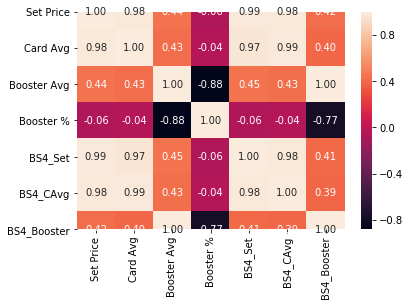

In [23]:
matriz_correlacao = compare_csv.corr()
#plt.figure(figsize = (11, 10))
ax = sns.heatmap(matriz_correlacao, annot = True, fmt = ".2f")
ax

Text(0.5, 0.98, 'Relacionando os dados BS4xCSV')

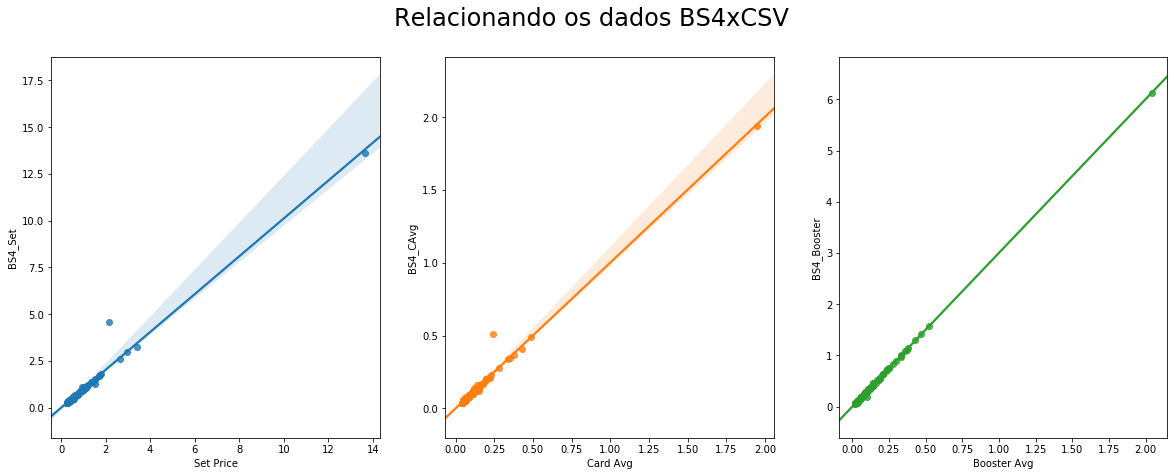

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(20, 7))
sns.regplot(x='Set Price', y='BS4_Set', data=compare_csv, ax=ax1)
sns.regplot(x='Card Avg', y='BS4_CAvg', data=compare_csv, ax=ax2)
sns.regplot(x='Booster Avg', y='BS4_Booster', data=compare_csv, ax=ax3)
fig.suptitle("Relacionando os dados BS4xCSV", fontsize=24)

Text(0.5, 0.98, 'Comparando os dados BS4xCSV')

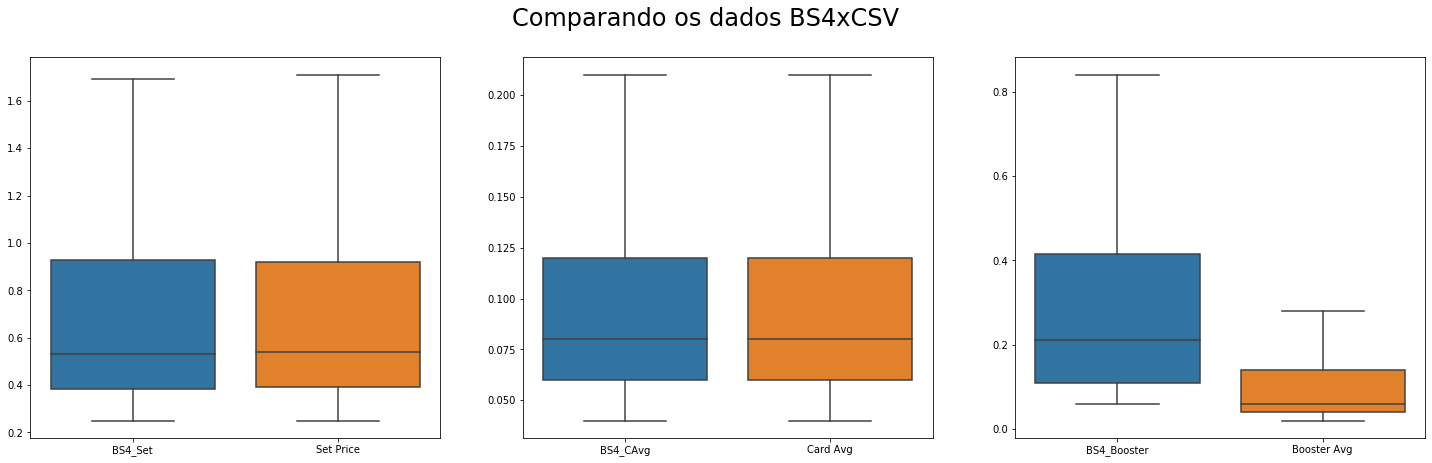

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(25, 7))
sns.boxplot(data=compare_csv[['BS4_Set', 'Set Price']], showfliers=False, ax=ax1)
sns.boxplot(data=compare_csv[['BS4_CAvg', 'Card Avg']], showfliers=False, ax=ax2)
sns.boxplot(data=compare_csv[['BS4_Booster', 'Booster Avg']], showfliers=False, ax=ax3)
fig.suptitle("Comparando os dados BS4xCSV", fontsize=24)



---

## **Há uma diferença bem clara na comparação dos boosters**

---





## Estudo dos nulos

In [0]:
import numpy as np
not_null_1 = compare_csv[~compare_csv['Booster Avg'].isna()][["BS4_Booster", "Booster Avg"]]

In [0]:
compare_sem_nulos = not_null_1[~not_null_1['BS4_Booster'].isna()]

Text(0.5, 1.0, 'Comparando os dados BS4xCSV sem nulos')

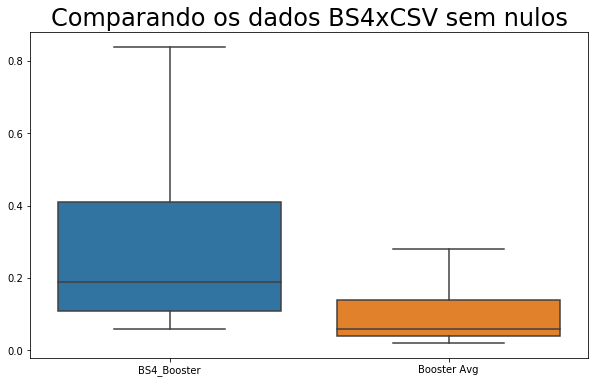

In [43]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=compare_sem_nulos, showfliers=False)
ax.set_title("Comparando os dados BS4xCSV sem nulos", fontsize=24)
#ax.figsize = (25, 7)



---

## **Essa verificação não foi relevante... talvez haja uma diferença bastante significativa ai**

---





In [45]:
compare_sem_nulos["Differença Booster"] = compare_sem_nulos["BS4_Booster"] - compare_sem_nulos["Booster Avg"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
compare_sem_nulos.head()

,BS4_Booster,Booster Avg,Differença Booster
8601,0.28,0.09,0.19
3609,0.24,0.08,0.16
2536,0.10,0.03,0.07
54,0.55,0.18,0.37
4786,0.09,0.03,0.06


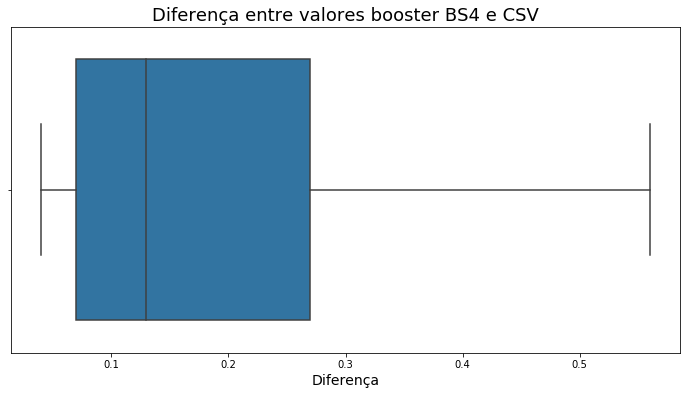

In [51]:
ax = sns.boxplot(compare_sem_nulos["Differença Booster"], showfliers=False)
ax.figure.set_size_inches(12, 6)
ax.set_title('Diferença entre valores booster BS4 e CSV', fontsize=18)
ax.set_xlabel('Diferença', fontsize=14)
ax

In [53]:
compare_sem_nulos["Differença Booster"].describe().round(2)

count    132.00
mean       0.24
std        0.39
min        0.04
25%        0.07
50%        0.13
75%        0.27
max        4.08
Name: Differença Booster, dtype: float64